# `CLOUD.jl` - 2D linear advection

In [47]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_collapsed_2D_test/"
results_path = "../results/advection_collapsed_2D_test/";

Define the physical problem

In [48]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=1.0);

Set up a collapsed-edge scheme of degree `p` with `M` intervals in each direction

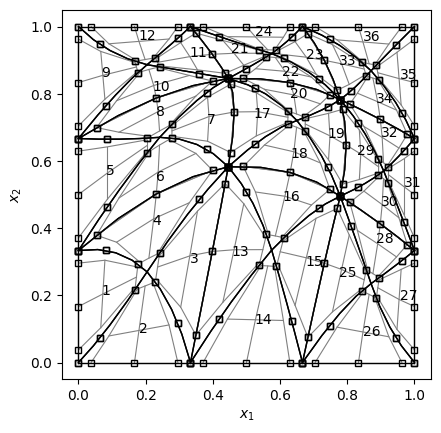

In [49]:
M = 3
p = 2
p_map = p
form = WeakConservationForm(
    SkewSymmetricMapping(),StandardCoupling())

reference_approximation_1 =ReferenceApproximation(
    DGSEM(p), CollapsedTri(),
    volume_quadrature_rule=(LGQuadrature(),LGRQuadrature()),
    facet_quadrature_rule=(LGQuadrature(),LGRQuadrature()), 
    chain_rule_diff=true, mapping_degree=p_map,
    N_plot=ceil(Int,50/M));

reference_approximation_2 =ReferenceApproximation(
    DGSEM(p), CollapsedTri(),
    volume_quadrature_rule=(LGQuadrature(),LGRQuadrature()),
    facet_quadrature_rule=(LGQuadrature(),LGRQuadrature()), 
    chain_rule_diff=false, mapping_degree=p_map,
    N_plot=ceil(Int,50/M));

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation_1.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), collapsed=true), 
    reference_approximation_1.reference_element, 0.15)

spatial_discretization_1 = SpatialDiscretization(mesh, 
    reference_approximation_1)
spatial_discretization_2 = SpatialDiscretization(mesh, 
    reference_approximation_2)

solver_1 = Solver(conservation_law, 
    spatial_discretization_1, form, Lazy())
solver_2 = Solver(conservation_law, 
    spatial_discretization_2, form, Lazy())

visualize(spatial_discretization_1, plots_path, "mesh.pdf", 
    grid_lines=true, plot_volume_nodes=false, label_elements=true)


In [50]:
ADV_chain = Tuple(Matrix(solver_1.operators[1].VOL[m]) for m in 1:2)
M_chain = Matrix(solver_1.operators[1].M)
ADV_chain[1]

9×9 Matrix{Float64}:
 -0.0473809    -0.00915711  …   0.0109944   0.0         0.0
  0.00231664   -0.0658436       0.0         0.0175911   0.0
  0.000917895   0.00436653      0.0         0.0         0.0109944
  0.0551408     0.0            -0.0354181   0.0         0.0
  0.0           0.0882253       0.0        -0.0566689   0.0
  0.0           0.0         …   0.0         0.0        -0.0354181
 -0.0109944     0.0             0.0582393  -0.0231397   0.0396723
  0.0          -0.0175911      -0.046136    0.0415941  -0.155544
  0.0           0.0             0.0123203   0.0206234   0.140295

In [51]:
ADV_nochain = Tuple(Matrix(solver_2.operators[1].VOL[m]) for m in 1:2)
M_nochain = Matrix(solver_1.operators[1].M)
ADV_nochain[1]

9×9 Matrix{Float64}:
 -0.0397765    0.00555275  -0.00606626  …   0.0703425   0.0         0.0
 -0.0138819   -0.0658436    0.0363126       0.0         0.109436    0.0
  0.00606626  -0.014525    -0.0761741       0.0         0.0         0.0664528
  0.054932     0.0          0.0            -0.226038    0.0         0.0
  0.0          0.086743     0.0             0.0        -0.348514    0.0
  0.0          0.0          0.0534967   …   0.0         0.0        -0.209605
 -0.0109067    0.0          0.0             0.228531    0.0421713  -0.031461
  0.0         -0.0169682    0.0            -0.105428    0.252395    0.147134
  0.0          0.0         -0.0103036       0.031461   -0.0588536   0.0244031

In [52]:
M_chain

9×9 Matrix{Float64}:
 0.00237787  0.0         0.0         …  0.0         0.0         0.0
 0.0         0.00336077  0.0            0.0         0.0         0.0
 0.0         0.0         0.00182309     0.0         0.0         0.0
 0.0         0.0         0.0            0.0         0.0         0.0
 0.0         0.0         0.0            0.0         0.0         0.0
 0.0         0.0         0.0         …  0.0         0.0         0.0
 0.0         0.0         0.0            0.00157187  0.0         0.0
 0.0         0.0         0.0            0.0         0.00247884  0.0
 0.0         0.0         0.0            0.0         0.0         0.00152669

In [53]:
M_nochain

9×9 Matrix{Float64}:
 0.00237787  0.0         0.0         …  0.0         0.0         0.0
 0.0         0.00336077  0.0            0.0         0.0         0.0
 0.0         0.0         0.00182309     0.0         0.0         0.0
 0.0         0.0         0.0            0.0         0.0         0.0
 0.0         0.0         0.0            0.0         0.0         0.0
 0.0         0.0         0.0         …  0.0         0.0         0.0
 0.0         0.0         0.0            0.00157187  0.0         0.0
 0.0         0.0         0.0            0.0         0.00247884  0.0
 0.0         0.0         0.0            0.0         0.0         0.00152669

In [54]:
mesh.xyz[1]

6×36 Matrix{Float64}:
  1.30276e-17  9.25186e-18  0.333333  …  0.779167  1.0       1.0
  0.110785     0.0933814    0.277452     0.825     0.944119  0.926715
  0.204167     0.204167     0.204167     0.870833  0.870833  0.870833
 -4.57271e-17  0.166667     0.398285     0.898285  1.0       0.833333
  0.0933814    0.277452     0.325        0.944119  0.926715  0.777452
 -3.70074e-17  0.333333     0.445833  …  1.0       1.0       0.666667

In [56]:
ones(9)' * ADV_chain[1]

1×9 adjoint(::Vector{Float64}) with eltype Float64:
 2.77556e-17  2.77556e-17  -2.77556e-17  …  -4.16334e-17  -4.16334e-17  0.0

In [57]:
NTR = Tuple(Matrix(solver_1.operators[1].NTR[m]) for m in 1:2)

([-0.16666666666666655 0.0 … 0.0 0.0; -0.0 -0.1666666666666667 … -0.0 -0.0; … ; 0.0 0.0 … 0.0 0.0; -0.01075063568172344 -0.020201188684493703 … 0.0 0.0], [2.3883661354270032e-17 0.0 … 0.0 0.0; 0.0 1.2684473789929658e-17 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.17089996946402078 -0.06805555555555609 … 0.0 0.0])

In [ ]:
numerical_flux(conservation_law.first_order_flux,)